<a href="https://colab.research.google.com/github/aayushhyadav/MIA/blob/feature%2Fmnist/MNIST_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow

In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from numpy import trapz
from sklearn.model_selection import KFold
import math
import statistics

In [2]:
'''
  # generates examples with equal class distribution
'''
def get_equal_class_distribution(data_x, data_y):
  class_dist = [0] * 10
  
  examples = list()
  train_X = list()
  train_y = list()

  for i in range(len(data_y)):
    if(class_dist[data_y[i]] <= 5400):
      class_dist[data_y[i]] += 1
      examples.append(i)
  
  for i in range(len(examples)):
    train_X.append(data_x[examples[i]])
    train_y.append(data_y[examples[i]])
  
  train_X = np.array(train_X)
  train_y = np.array(train_y)

  print(f"{data_x.shape, train_X.shape}")
  print(f"{data_y.shape, train_y.shape}")
  
  return train_X, train_y

In [3]:
'''
  # loads mnist dataset
  # flattens the dataset
  # performs one hot encoding on target values
'''
def load_dataset():
  (train_X, train_y), (test_X, test_y) = tf.keras.datasets.mnist.load_data()
  
  class_examples_train = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  class_examples_test = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

  train_X, train_y = get_equal_class_distribution(train_X, train_y)

  for example in train_y:
    class_examples_train[example] += 1
  for example in test_y:
    class_examples_test[example] += 1

  for i in range(9):
    plt.subplot(331 + i)
    plt.imshow(train_X[i], cmap='gray')
  plt.show()

  print(f'class distribution for training dataset - {class_examples_train}')
  print(f'class distribution for testing dataset - {class_examples_test}')
  
  flat_train_X = train_X.reshape((train_X.shape[0], 28, 28, 1))
  flat_test_X = test_X.reshape((test_X.shape[0], 28, 28, 1))
  
  ohe_train_y = pd.get_dummies(train_y)
  ohe_test_y = pd.get_dummies(test_y)

  return flat_train_X, flat_test_X, ohe_train_y.to_numpy(), ohe_test_y.to_numpy()

11490434/11490434 [==============================] - 0s 0us/step
((60000, 28, 28), (54010, 28, 28))
((60000,), (54010,))


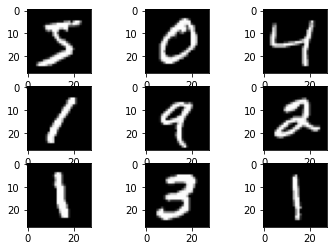

class distribution for training dataset - [5401, 5401, 5401, 5401, 5401, 5401, 5401, 5401, 5401, 5401]
class distribution for testing dataset - [980, 1135, 1032, 1010, 982, 892, 958, 1028, 974, 1009]


In [4]:
train_X, test_X, train_y, test_y = load_dataset()

In [5]:
'''
  # perfroms feature scaling on training and test sets
'''
def standardize(train, test):
  train_norm = train.astype('float32')
  test_norm = test.astype('float32')
  
  train_norm = train_norm / 255.0
  test_norm = test_norm / 255.0

  return train_norm, test_norm

In [6]:
train_norm, test_norm = standardize(train_X, test_X)

In [7]:
'''
  # creates a 2d CNN
'''
def create_model():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
  model.add(tf.keras.layers.MaxPool2D((2, 2)))

  model.add(tf.keras.layers.Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_uniform'))
  model.add(tf.keras.layers.MaxPool2D((2, 2)))
  
  model.add(tf.keras.layers.Flatten())
  
  model.add(tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(tf.keras.layers.Dense(10, activation='softmax'))
  
  model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

  return model

In [8]:
'''
  # evaluates the model using k-fold method
  # data_X - training examples
  # data_y - testing examples
  # n_folds - number of folds
  # returns list of accuracy of models on validation data, list of fitted models, and list of sequential models
'''
def evaluate_model(data_X, data_y, n_folds = 5):
  scores, history, models = list(), list(), list()
  kfold = KFold(n_folds, shuffle = True, random_state = 1)
  for cur_train_X, cur_test_X in kfold.split(data_X):
    model = create_model()
    models.append(model)

    train_X, train_y, test_X, test_y = data_X[cur_train_X], data_y[cur_train_X], data_X[cur_test_X], data_y[cur_test_X]
    history.append(model.fit(train_X, train_y, epochs = 10, batch_size = 32, validation_data = (test_X, test_y)))

    _, acc = model.evaluate(test_X, test_y)
    scores.append(acc)
  return scores, history, models

In [9]:
scores, history, models = evaluate_model(train_norm, train_y)

Epoch 1/10
1351/1351 [==============================] - 56s 41ms/step - loss: 0.1594 - accuracy: 0.9501 - val_loss: 0.0710 - val_accuracy: 0.9784
Epoch 2/10
1351/1351 [==============================] - 44s 33ms/step - loss: 0.0548 - accuracy: 0.9834 - val_loss: 0.0589 - val_accuracy: 0.9818
Epoch 3/10
1351/1351 [==============================] - 48s 35ms/step - loss: 0.0358 - accuracy: 0.9886 - val_loss: 0.0483 - val_accuracy: 0.9856
Epoch 4/10
1351/1351 [==============================] - 44s 33ms/step - loss: 0.0272 - accuracy: 0.9912 - val_loss: 0.0480 - val_accuracy: 0.9862
Epoch 5/10
1351/1351 [==============================] - 45s 34ms/step - loss: 0.0193 - accuracy: 0.9936 - val_loss: 0.0388 - val_accuracy: 0.9876
Epoch 6/10
1351/1351 [==============================] - 44s 33ms/step - loss: 0.0146 - accuracy: 0.9952 - val_loss: 0.0472 - val_accuracy: 0.9861
Epoch 7/10
1351/1351 [==============================] - 44s 33ms/step - loss: 0.0107 - accuracy: 0.9966 - val_loss: 0.0368 -

In [10]:
# scores for the 5 trained models
scores

[0.9887983798980713,
 0.9900018572807312,
 0.9867616891860962,
 0.9883354902267456,
 0.9887983798980713]

In [11]:
'''
  # plots the loss and accuracy for training and validation sets
'''
def plot_learning_curves(history):
  fig, (ax1, ax2) = plt.subplots(1, 2)
  for model in history:
    ax1.set_title('Cross Entropy Loss')
    ax1.plot(model.history['loss'], color = 'blue', label = 'train')
    ax1.plot(model.history['val_loss'], color = 'red', label = 'validation')

    ax2.set_title('Accuracy')
    ax2.plot(model.history['accuracy'], color = 'blue', label = 'train')
    ax2.plot(model.history['val_accuracy'], color = 'red', label = 'validation')
  plt.show()

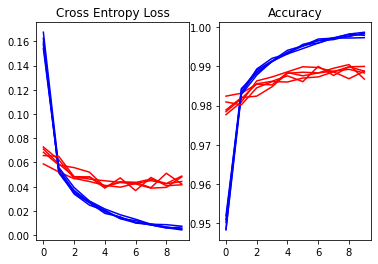

In [12]:
plot_learning_curves(history)

In [13]:
prob_vec_train = models[3].predict(train_norm)
prob_vec_test = models[3].predict(test_norm)

313/313 [==============================] - 3s 9ms/step


In [14]:
prob_vec_train[0]

array([2.2886854e-16, 2.7596842e-14, 8.0775204e-18, 6.6162081e-04,
       7.0266811e-19, 9.9933833e-01, 2.9981222e-15, 1.2249014e-14,
       2.7206473e-11, 1.1459582e-09], dtype=float32)

In [15]:
prob_vec_test[0]

array([1.6809955e-15, 1.0165573e-12, 3.0183304e-11, 5.1053019e-11,
       1.0412826e-18, 9.3484477e-15, 1.4918011e-19, 9.9999994e-01,
       1.0111701e-15, 2.3351539e-11], dtype=float32)

In [16]:
'''
  # computes entropy for probability vectors
  # prob_vec - probability vector
'''
def cal_entropy(prob_vec):
  entropy = 0
  for prob in prob_vec:
    entropy = entropy + prob * math.log(prob, 10)
  return -1 * entropy

In [23]:
'''
  # computes standard deviation for probability vector
'''
def cal_std(prob_vec):
  mean = statistics.mean(prob_vec)
  variance = 0

  for prob in prob_vec:
    variance += (prob - mean) ** 2
  variance /= len(prob_vec)

  return math.sqrt(variance)

In [24]:
# compute average entropy and standard deviation for probability vector of training examples
# stores the entropy and standard deviation for each probability vector

entropy_train = list()
std_train = list()

sum_entropy = 0
sum_std = 0

for prob_vec in prob_vec_train:
  cur_entropy = cal_entropy(prob_vec)
  cur_std = cal_std(prob_vec)

  entropy_train.append(cur_entropy)
  std_train.append(cur_std)

  sum_entropy = sum_entropy + cur_entropy
  sum_std = sum_std + cur_std

avg_train_entropy = sum_entropy / len(prob_vec_train)
avg_train_std = sum_std / len(prob_vec_train)

print(f"Avg train entropy - {avg_train_entropy}, Avg train std - {avg_train_std}")

Avg train entropy - 0.002924969237329546, Avg train std - 0.29938625547437236


In [25]:
# compute average entropy and standard deviation for probability vector of testing examples
# stores the entropy and standard deviation for each probability vector

entropy_test = list()
std_test = list()

sum_entropy = 0
sum_std = 0

for prob_vec in prob_vec_test:
  cur_entropy = cal_entropy(prob_vec)
  cur_std = cal_std(prob_vec)

  entropy_test.append(cur_entropy)
  std_test.append(cur_std)

  sum_entropy = sum_entropy + cur_entropy
  sum_std = sum_std + cur_std

avg_test_entropy = sum_entropy / len(prob_vec_test)
avg_test_std = sum_std / len(prob_vec_test)

print(f"Avg test entropy - {avg_test_entropy}, Avg test std - {avg_test_std}")

Avg test entropy - 0.0047683984399023265, Avg test std - 0.29887319948411706


In [1]:
'''
  # calculates AUC score for attack model using trapezoidal method
  # train_vec - entropy for probability vectors of training examples
  # test_vec - entropy for probability vectors of testing examples
  # pos_count - number of examples which are members of training set
  # neg_count - number of examples which are non-members of training set
  # inc_threshold - controls the number of thresholds for which AUC is computed
'''
def cal_auc(train_vec, test_vec, pos_count, neg_count, inc_threshold = 0.1):
  threshold = 0
  tpr_list, fpr_list = list(), list()
  tuple_tpr, tuple_fpr = list(), list()
  points = list()
  auc = 0

  while(threshold <= 1):
    tp_count = 0
    fp_count = 0

    for val in train_vec:
      if(val <= threshold):
        tp_count += 1
      
    for val in test_vec:
      if(val <= threshold):
        fp_count += 1

    tpr = tp_count / pos_count
    fpr = fp_count / neg_count
    
    tpr_list.append(tpr)
    fpr_list.append(fpr)

    threshold += inc_threshold

  for i in range(len(tpr_list)):
    points.append([fpr_list[i], tpr_list[i]])

  points.sort()

  for i in range(len(points) - 1):
    tuple_tpr.append([points[i][1], points[i + 1][1]])
    tuple_fpr.append([points[i][0], points[i + 1][0]])

  auc = sum(np.trapz(tuple_tpr, tuple_fpr))
  return auc

In [ ]:
cal_auc(entropy_train, entropy_test, len(entropy_train), len(entropy_test), 0.00001)

In [26]:
# calculate auc score using entropy as the parameter
cal_auc(std_train, std_test, len(std_train), len(std_test), 0.00001)

0.5008830244399185